TAKE DATA FROM CLOUD FIRESTORE AND TRANSFORM THEM IN CSV

In [ ]:
import pandas as pd
import numpy as np
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
#cred = credentials.Certificate("path_to/narciso-4e261-firebase-adminsdk-qq6t0-9dba8025d1.json")
firebase_admin.initialize_app(cred)
 
db = firestore.client()
data_coll = db.collection("data")
 
data = data_coll.get()

position_axis = ["x", "y"]
faceParts = ["leftCheek", "leftEar", "leftEye", "mouthBottom", "mouthLeft", "mouthRight", "noseBase", "rightCheek", "rightEar", "rightEye"]
channels = ["channel1", "channel2", "channel3", "channel4", "channel5", "channel6"]
 
df = pd.DataFrame()
df_EEG = pd.DataFrame()
 
for doc in data:
  if doc.exists:
    # print(f"Doc name: {doc.id}")
    # print(f"Documento preso: {doc.to_dict()}")
    usable_doc = doc.to_dict()
    for part in faceParts:
      # print(f"Parte faccia: {part} con")
      for axis in position_axis:
        # print(f"{axis}: {usable_doc['faceData'][part][axis]}")
        new_col = part+"_"+axis
        usable_doc[new_col] = usable_doc['faceData'][part][axis]
    del usable_doc["faceData"]
    # print(f"{usable_doc}\n")
 
    usable_doc_EEG = usable_doc.copy()
    EEG_coll = data_coll.document(doc.id).collection("EEGdata")
    EEG_data = EEG_coll.get()
    for sample_doc in EEG_data:
      if sample_doc.exists:
        usable_doc_EEG["testID"] = doc.id+"_EEG_"+sample_doc.id
        # print(f"Sample: {sample_doc.id}")
        # print(f"Sample values: {sample_doc.to_dict()}")
        usable_EEG_sample = sample_doc.to_dict()
        for channel in channels:
          usable_doc_EEG[channel] = usable_EEG_sample[channel]
        df_EEG_data_curr = pd.DataFrame.from_dict(usable_doc_EEG, orient='index').T
        df_EEG = pd.concat([df_EEG, df_EEG_data_curr], ignore_index=True)
      else:
        print("EEG data doesn't exist")
 
    usable_doc["testID"] = doc.id
    df_data_curr = pd.DataFrame.from_dict(usable_doc, orient='index').T
    df = pd.concat([df, df_data_curr], ignore_index=True)
  else:
    print("No doc found")
#print(df)
df.to_csv("/content/drive/MyDrive/Narciso/csv_data.csv", index = False)
#print(df_EEG)
df_EEG.to_csv("/content/drive/MyDrive/Narciso/csv_data_with_EEG.csv", index = False)

MODELLO SENZA EEG

Accuracy: 0.35714285714285715
              precision    recall  f1-score   support

          -1       0.09      0.06      0.07        18
           0       0.44      0.50      0.47        22
           1       0.40      0.50      0.44        16

    accuracy                           0.36        56
   macro avg       0.31      0.35      0.33        56
weighted avg       0.32      0.36      0.33        56

Predictions saved to C:\Users\Utente\Downloads\csv_data_with_predictions.csv
Feature importances: [ 0.00714286 -0.04285714  0.08214286  0.02678571  0.01964286  0.
  0.00714286  0.01607143  0.00357143  0.02142857  0.00714286  0.
  0.00892857  0.00535714  0.00892857  0.         -0.00178571  0.00178571
  0.         -0.00535714  0.00357143  0.00892857  0.        ]
          feature  importance
2             ppg    0.082143
3     leftCheek_x    0.026786
9   mouthBottom_x    0.021429
4     leftCheek_y    0.019643
7       leftEye_x    0.016071
21     rightEye_x    0.008929
12    mouthLeft_

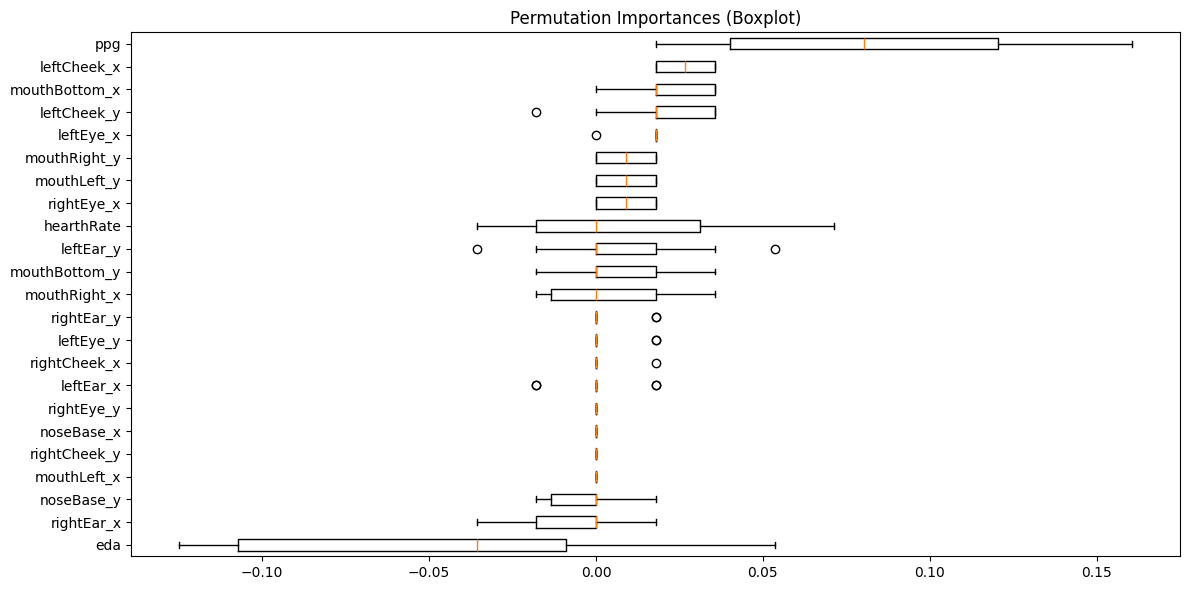

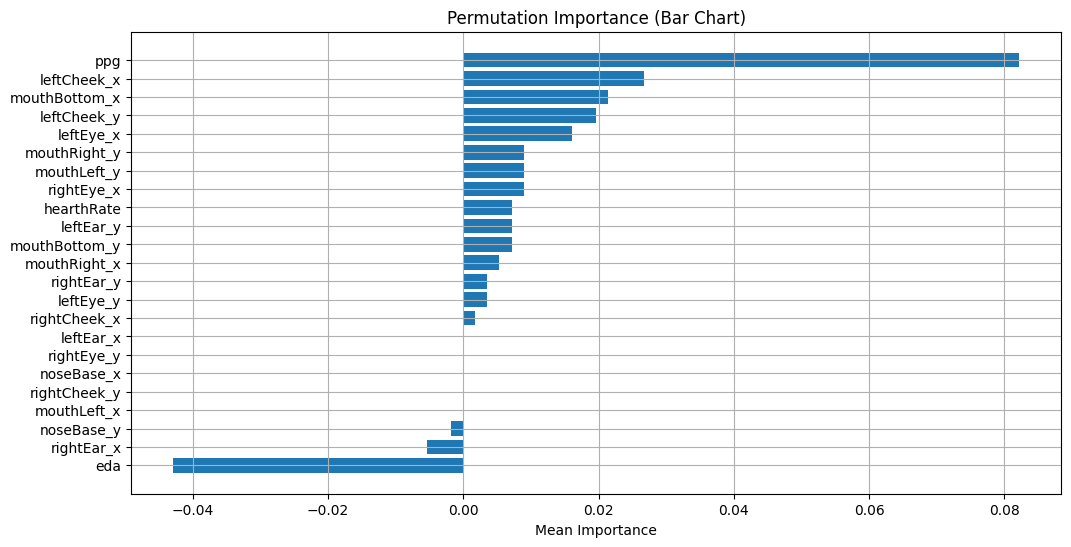

In [4]:
#pip install --upgrade firebase_admin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
 

# Carica il dataset
file_path = "C:\\Users\\Utente\\Downloads\\csv_data.csv"
data = pd.read_csv(file_path)

# Seleziona le feature e il target, escludendo la colonna testUser
features = [
    'hearthRate', 'eda', 'ppg', 'leftCheek_x', 'leftCheek_y',
    'leftEar_x', 'leftEar_y', 'leftEye_x', 'leftEye_y', 'mouthBottom_x',
    'mouthBottom_y', 'mouthLeft_x', 'mouthLeft_y', 'mouthRight_x',
    'mouthRight_y', 'noseBase_x', 'noseBase_y', 'rightCheek_x', 'rightCheek_y',
    'rightEar_x', 'rightEar_y', 'rightEye_x', 'rightEye_y'
]
target = 'likability'

X = data[features]
y = data[target]

# Suddividi il dataset in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea e addestra il modello
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Effettua previsioni sul test set
y_pred = clf.predict(X_test)

# Valuta il modello
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Effettua previsioni su tutto il dataset
data['predicted_likability'] = clf.predict(X)

# Salva i risultati in un nuovo CSV
output_file_path = "C:\\Users\\Utente\\Downloads\\csv_data_with_predictions.csv"
data.to_csv(output_file_path, index=False)

print(f"Predictions saved to {output_file_path}")

# Calcolare l'importanza delle caratteristiche
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Estrarre l'importanza media
feature_importances = result.importances_mean
print("Feature importances:", feature_importances)

# Associa le importanze delle caratteristiche ai nomi delle feature
importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
importances = importances.sort_values(by='importance', ascending=False)

# Stampa le importanze ordinate
print(importances)

# Plot dell'importanza delle caratteristiche
sorted_idx = np.argsort(result.importances_mean)
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features)[sorted_idx])
ax.set_title("Permutation Importances (Boxplot)")
fig.tight_layout()

# Plot delle importanze medie
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.xlabel('Mean Importance')
plt.title('Permutation Importance (Bar Chart)')
plt.grid(True)
plt.show()


MODELLO CON EEG

Accuracy: 0.8987341772151899
              precision    recall  f1-score   support

          -1       0.86      0.94      0.90        52
           0       0.93      0.85      0.88        59
           1       0.91      0.91      0.91        47

    accuracy                           0.90       158
   macro avg       0.90      0.90      0.90       158
weighted avg       0.90      0.90      0.90       158

Predictions saved to C:\Users\Utente\Downloads\csv_data_with_predictions.csv
Feature importances: [ 0.07341772  0.15822785  0.25189873  0.         -0.00126582  0.
  0.         -0.00063291 -0.00253165  0.          0.         -0.00443038
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.0221519
  0.01518987  0.00316456  0.02341772  0.00443038  0.01265823]
          feature  importance
2             ppg    0.251899
1             eda    0.158228
0      hearthRate    0.073418
26       channel4    0.023418
23   

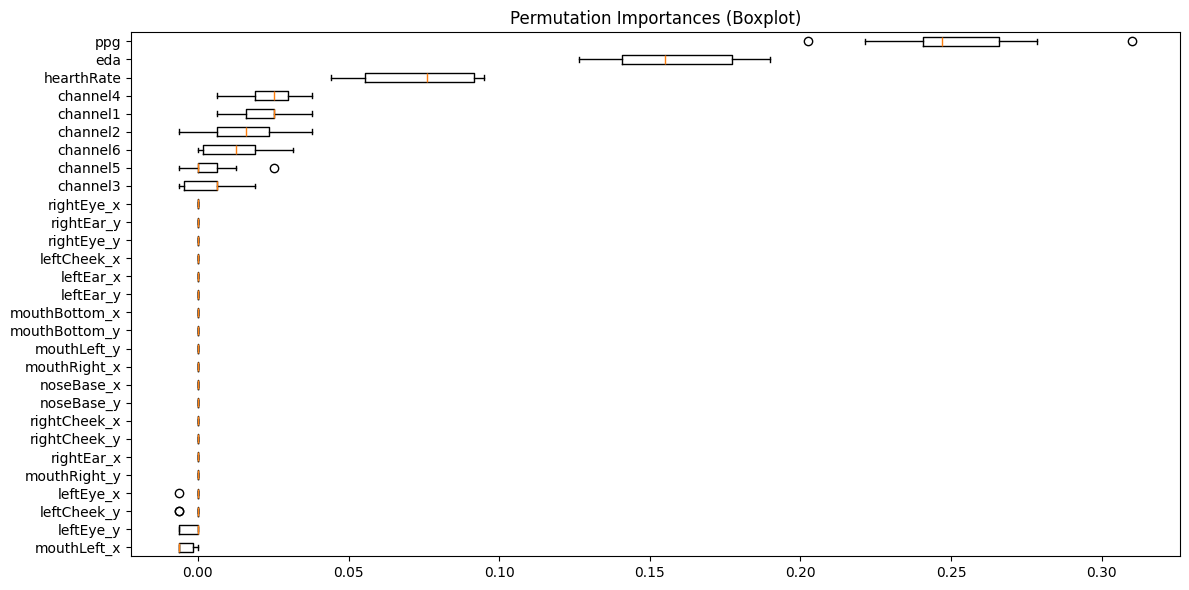

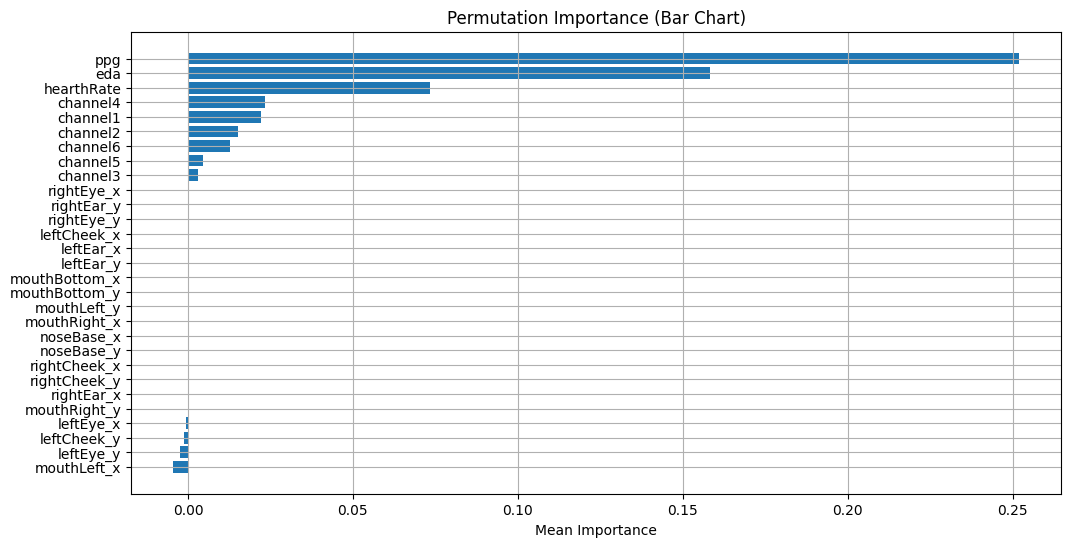

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Carica il dataset
file_path = "C:\\Users\\Utente\\Downloads\\csv_data_with_EEG.csv"
data = pd.read_csv(file_path)

# Seleziona le feature e il target
features = [
    'hearthRate', 'eda', 'ppg', 'leftCheek_x', 'leftCheek_y',
    'leftEar_x', 'leftEar_y', 'leftEye_x', 'leftEye_y', 'mouthBottom_x',
    'mouthBottom_y', 'mouthLeft_x', 'mouthLeft_y', 'mouthRight_x',
    'mouthRight_y', 'noseBase_x', 'noseBase_y', 'rightCheek_x', 'rightCheek_y',
    'rightEar_x', 'rightEar_y', 'rightEye_x', 'rightEye_y',
    'channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6'
]
target = 'likability'

X = data[features]
y = data[target]

# Suddividere il dataset in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creare e addestrare il modello
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Effettuare previsioni sul test set
y_pred = clf.predict(X_test)

# Valutare il modello
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Effettuare previsioni su tutto il dataset
data['predicted_likability'] = clf.predict(X)

# Salvare i risultati in un nuovo CSV
output_file_path = "C:\\Users\\Utente\\Downloads\\csv_data_with_predictions.csv"
data.to_csv(output_file_path, index=False)

print(f"Predictions saved to {output_file_path}")

# Calcolare l'importanza delle caratteristiche
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Estrarre l'importanza media
feature_importances = result.importances_mean
print("Feature importances:", feature_importances)

# Associare le importanze delle caratteristiche ai nomi delle feature
importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
importances = importances.sort_values(by='importance', ascending=False)

# Stampare le importanze ordinate
print(importances)

# Plot dell'importanza delle caratteristiche
sorted_idx = np.argsort(result.importances_mean)
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features)[sorted_idx])
ax.set_title("Permutation Importances (Boxplot)")
fig.tight_layout()

# Plot delle importanze medie
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.xlabel('Mean Importance')
plt.title('Permutation Importance (Bar Chart)')
plt.grid(True)
plt.show()
